In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

In [2]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


In [3]:
%%bigquery unique_orders --project fb-business-datasets
SELECT order_number, created_at, email, `interval`, Total_Net, source_channel
FROM fb-business-datasets.ds_tables.unique_orders_newest

Query is running:   0%|          |

Downloading:   0%|          |

In [4]:
# import the newest cleaned_shopify_orderlines data
%%bigquery cleaned_orderlines --project fb-business-datasets
SELECT order_number, created_at, shipping_address_province_code, email, source_channel, sku, title, quantity, revenue, net
FROM fb-business-datasets.ds_tables.cleaned_shopify_orderlines_newest

Query is running:   0%|          |

Downloading:   0%|          |

In [5]:
%%bigquery customer_cluster --project fb-business-datasets
SELECT email, Most_Commonly_Used_Channel, Main_Channel, cluster_clv, cluster_rfm5, cluster_rfmx, cluster_cb
FROM fb-business-datasets.ds_tables.customer_cluster_newest

Query is running:   0%|          |

Downloading:   0%|          |

In [6]:
suffix_mcus = '_mcus'
customer_cluster['Most_Commonly_Used_Channel'] = customer_cluster['Most_Commonly_Used_Channel'].astype(str) + suffix_mcus
suffix_main = '_main'
customer_cluster['Main_Channel'] = customer_cluster['Main_Channel'].astype(str) + suffix_main
suffix_clv = '_clv'
customer_cluster['cluster_clv'] = customer_cluster['cluster_clv'].astype(str) + suffix_clv
suffix_rfm5 = '_rfm5'
customer_cluster['cluster_rfm5'] = customer_cluster['cluster_rfm5'].astype(str) + suffix_rfm5
suffix_rfmx = '_rfmx'
customer_cluster['cluster_rfmx'] = customer_cluster['cluster_rfmx'].astype(str) + suffix_rfmx
suffix_cb = '_cb'
customer_cluster['cluster_cb'] = customer_cluster['cluster_cb'].astype(str) + suffix_cb

In [7]:
unique_orders = unique_orders.merge(customer_cluster, on='email')
unique_orders.columns

Index(['order_number', 'created_at', 'email', 'interval', 'Total_Net',
       'source_channel', 'Most_Commonly_Used_Channel', 'Main_Channel',
       'cluster_clv', 'cluster_rfm5', 'cluster_rfmx', 'cluster_cb'],
      dtype='object')

In [8]:
cleaned_orderlines = cleaned_orderlines.merge(customer_cluster, on='email', how='inner')
cleaned_orderlines.columns

Index(['order_number', 'created_at', 'shipping_address_province_code', 'email',
       'source_channel', 'sku', 'title', 'quantity', 'revenue', 'net',
       'Most_Commonly_Used_Channel', 'Main_Channel', 'cluster_clv',
       'cluster_rfm5', 'cluster_rfmx', 'cluster_cb'],
      dtype='object')

## Holiday & Sales

In [9]:
holidays = {
    'New Year': [(2023, 1, 1), (2024, 1, 1)],
    'Super Bowl': [(2023, 2, 12), (2024, 2, 11)],
    'Valentine\'s Day': [(2023, 2, 14), (2024, 2, 14)],
    'Presidents\' Day': [(2023, 2, 20), (2024, 2, 19)],
    'International Women\'s Day': [(2023, 3, 8), (2024, 3, 8)],
    'Pi Day': [(2023, 3, 14), (2024, 3, 14)],
    'St Patrick\'s Day': [(2023, 3, 17), (2024, 3, 17)],
    'Easter': [(2023, 4, 9), (2024, 3, 31)],
    'Earth Day': [(2023, 4, 22), (2024, 4, 22)],
    'Mother\'s Day': [(2023, 5, 14), (2024, 5, 12)],
    'Father\'s Day': [(2023, 6, 18), (2024, 6, 16)],
    'Independence Day': [(2023, 7, 4), (2024, 7, 4)],
    'Labor Day': [(2023, 9, 4), (2024, 9, 2)],
    'Halloween': [(2023, 10, 31), (2024, 10, 31)],
    'Thanksgiving': [(2023, 11, 23,), (2024, 11, 28)],
    'Black Friday': [(2023, 11, 24), (2024, 11, 29)],
    'Cyber Monday': [(2023, 11, 27), (2024, 12, 2)],
    'Super Saturday': [(2023, 12, 15), (2024, 12, 21)],
    'Christmas': [(2023, 12, 25), (2024, 12, 25)]
}
for holiday, dates in holidays.items():
    holidays[holiday] = [datetime(year, month, day) for year, month, day in dates]

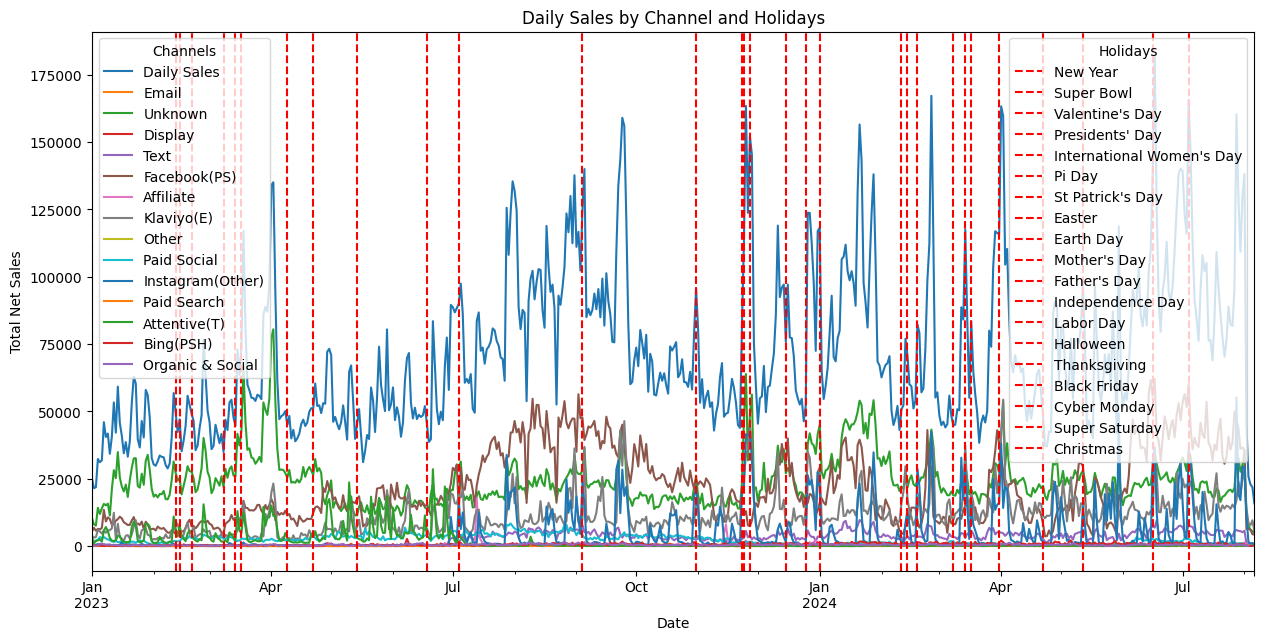

In [10]:
# Example setup; assume unique_orders DataFrame and holidays dictionary are predefined
plt.figure(figsize=(15, 7))

# Plotting daily sales
daily_sales = unique_orders.groupby(pd.Grouper(key="created_at", freq="D"))["Total_Net"].sum()
daily_sales_plot = daily_sales.plot(label='Daily Sales')

# Handles for legends
channel_handles = [daily_sales_plot]  # Start with the handle for daily sales
channel_labels = ['Daily Sales']  # Label for daily sales

# Plotting sales for each channel
for channel in unique_orders.source_channel.unique():
    channel_sales = unique_orders[unique_orders['source_channel'] == channel].groupby(pd.Grouper(key="created_at", freq="D"))["Total_Net"].sum()
    channel_plot = channel_sales.plot(label=channel)  # Plot and store the Axes object
    # No need to append here; the label is automatically added to the legend

# Marking holidays on the plot
holiday_handles, holiday_labels = [], []
for holiday, dates in holidays.items():
    for date in dates:
        line = plt.axvline(x=date, color='red', linestyle='--')
        if holiday not in holiday_labels:
            holiday_handles.append(line)
            holiday_labels.append(holiday)

# Creating and positioning legends
first_legend = plt.legend(loc='upper left', title="Channels")
plt.gca().add_artist(first_legend)  # Add the first legend manually
second_legend = plt.legend(handles=holiday_handles, labels=holiday_labels, loc='upper right', title="Holidays")

plt.title('Daily Sales by Channel and Holidays')
plt.xlabel('Date')
plt.ylabel('Total Net Sales')
plt.show()

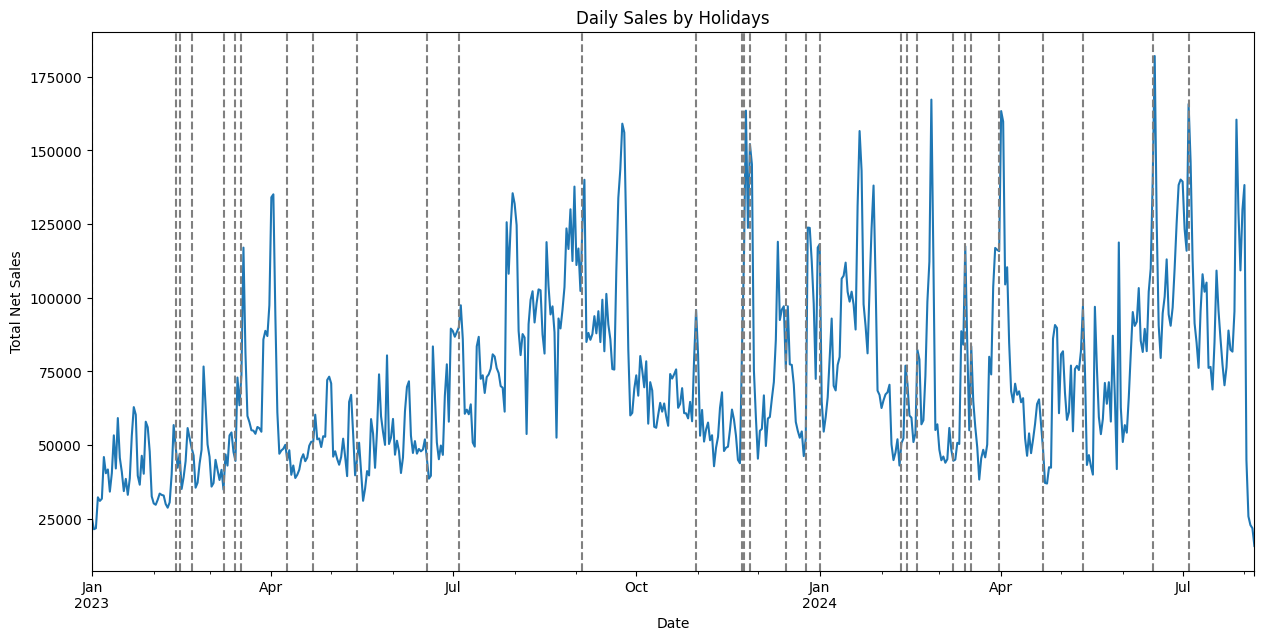

In [11]:
# Example setup; assume unique_orders DataFrame and holidays dictionary are predefined
plt.figure(figsize=(15, 7))

# Plotting daily sales
daily_sales = unique_orders.groupby(pd.Grouper(key="created_at", freq="D"))["Total_Net"].sum()
daily_sales_plot = daily_sales.plot(label='Daily Sales')

# Marking holidays on the plot
holiday_handles, holiday_labels = [], []
for holiday, dates in holidays.items():
    for date in dates:
        line = plt.axvline(x=date, color='grey', linestyle='--')
        if holiday not in holiday_labels:
            holiday_handles.append(line)
            holiday_labels.append(holiday)

plt.title('Daily Sales by Holidays')
plt.xlabel('Date')
plt.ylabel('Total Net Sales')
plt.show()

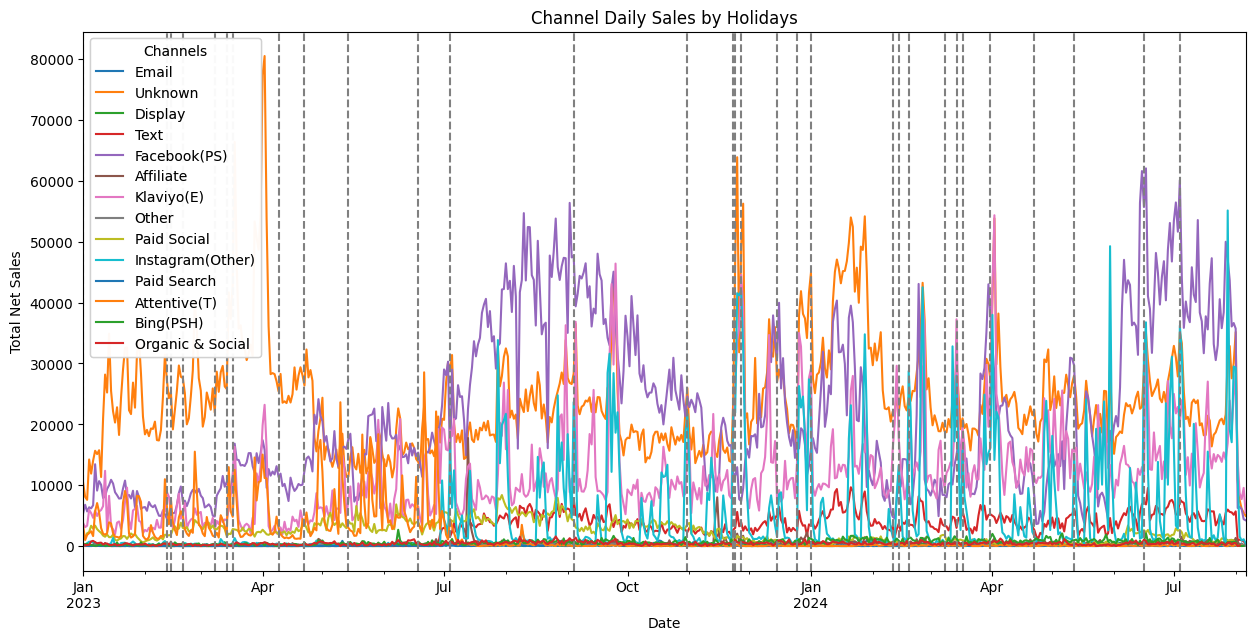

In [12]:
# Example setup; assume unique_orders DataFrame and holidays dictionary are predefined
plt.figure(figsize=(15, 7))

# Plotting sales for each channel
for channel in unique_orders.source_channel.unique():
    channel_sales = unique_orders[unique_orders['source_channel'] == channel].groupby(pd.Grouper(key="created_at", freq="D"))["Total_Net"].sum()
    channel_plot = channel_sales.plot(label=channel)  # Plot and store the Axes object
    # No need to append here; the label is automatically added to the legend

# Marking holidays on the plot
holiday_handles, holiday_labels = [], []
for holiday, dates in holidays.items():
    for date in dates:
        line = plt.axvline(x=date, color='grey', linestyle='--')
        if holiday not in holiday_labels:
            holiday_handles.append(line)
            holiday_labels.append(holiday)

# Creating and positioning legends
first_legend = plt.legend(loc='upper left', title="Channels")
plt.gca().add_artist(first_legend)  # Add the first legend manually

plt.title('Channel Daily Sales by Holidays')
plt.xlabel('Date')
plt.ylabel('Total Net Sales')
plt.show()

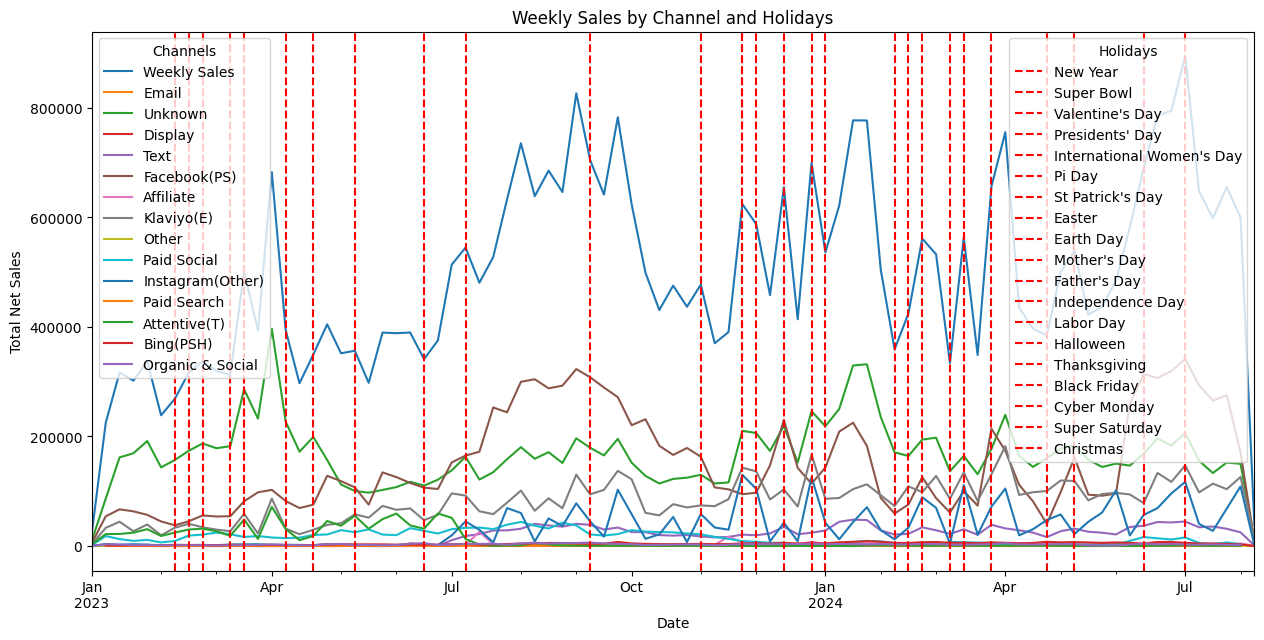

In [13]:
# Example setup; assume unique_orders DataFrame and holidays dictionary are predefined
plt.figure(figsize=(15, 7))

# Plotting weekly sales
weekly_sales = unique_orders.groupby(pd.Grouper(key="created_at", freq="W"))["Total_Net"].sum()
weekly_sales_plot = weekly_sales.plot(label='Weekly Sales')

# Handles for legends
channel_handles = [weekly_sales_plot]  # Start with the handle for weekly sales
channel_labels = ['Weekly Sales']  # Label for weekly sales

# Plotting sales for each channel
for channel in unique_orders.source_channel.unique():
    channel_sales = unique_orders[unique_orders['source_channel'] == channel].groupby(pd.Grouper(key="created_at", freq="W"))["Total_Net"].sum()
    channel_plot = channel_sales.plot(label=channel)  # Plot and store the Axes object
    # No need to append here; the label is automatically added to the legend

# Marking holidays on the plot
holiday_handles, holiday_labels = [], []
for holiday, dates in holidays.items():
    for date in dates:
        line = plt.axvline(x=date, color='r', linestyle='--')
        if holiday not in holiday_labels:
            holiday_handles.append(line)
            holiday_labels.append(holiday)

# Creating and positioning legends
first_legend = plt.legend(loc='upper left', title="Channels")
plt.gca().add_artist(first_legend)  # Add the first legend manually
second_legend = plt.legend(handles=holiday_handles, labels=holiday_labels, loc='upper right', title="Holidays")

plt.title('Weekly Sales by Channel and Holidays')
plt.xlabel('Date')
plt.ylabel('Total Net Sales')
plt.show()

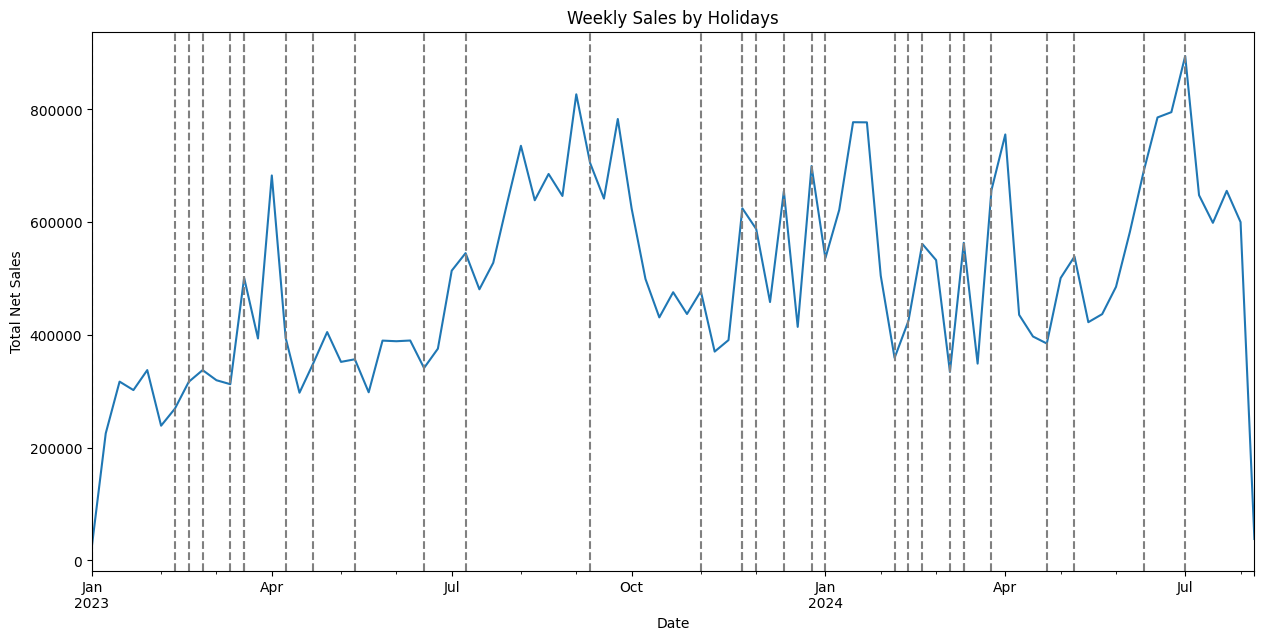

In [14]:
# Example setup; assume unique_orders DataFrame and holidays dictionary are predefined
plt.figure(figsize=(15, 7))

# Plotting daily sales
weekly_sales = unique_orders.groupby(pd.Grouper(key="created_at", freq="W"))["Total_Net"].sum()
weekly_sales_plot = weekly_sales.plot(label='Weekly Sales')

# Marking holidays on the plot
holiday_handles, holiday_labels = [], []
for holiday, dates in holidays.items():
    for date in dates:
        line = plt.axvline(x=date, color='grey', linestyle='--')
        if holiday not in holiday_labels:
            holiday_handles.append(line)
            holiday_labels.append(holiday)

plt.title('Weekly Sales by Holidays')
plt.xlabel('Date')
plt.ylabel('Total Net Sales')
plt.show()

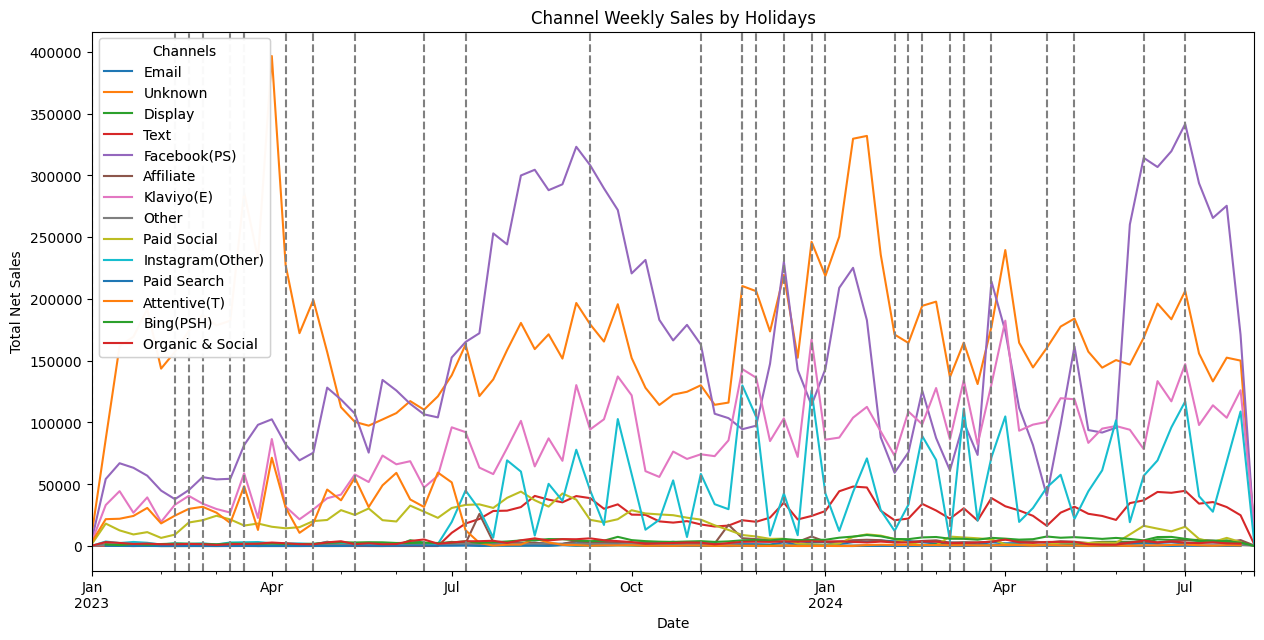

In [15]:
# Example setup; assume unique_orders DataFrame and holidays dictionary are predefined
plt.figure(figsize=(15, 7))

# Plotting sales for each channel
for channel in unique_orders.source_channel.unique():
    channel_sales = unique_orders[unique_orders['source_channel'] == channel].groupby(pd.Grouper(key="created_at", freq="W"))["Total_Net"].sum()
    channel_plot = channel_sales.plot(label=channel)  # Plot and store the Axes object
    # No need to append here; the label is automatically added to the legend

# Marking holidays on the plot
holiday_handles, holiday_labels = [], []
for holiday, dates in holidays.items():
    for date in dates:
        line = plt.axvline(x=date, color='grey', linestyle='--')
        if holiday not in holiday_labels:
            holiday_handles.append(line)
            holiday_labels.append(holiday)

# Creating and positioning legends
first_legend = plt.legend(loc='upper left', title="Channels")
plt.gca().add_artist(first_legend)  # Add the first legend manually

plt.title('Channel Weekly Sales by Holidays')
plt.xlabel('Date')
plt.ylabel('Total Net Sales')
plt.show()

In [16]:
# Create a new column `main_source_channel` based on `source_channel`
mapping = {
    'Facebook(PS)': 'Paid Social',
    'Paid Social': 'Paid Social',
    'Affiliate': 'Affiliate',
    'Klaviyo(E)': 'Email',
    'Email': 'Email',
    'Instagram(Other)': 'Other',
    'Other': 'Other',
    'Unknown': 'Unknown',
    'Bing(PSH)':'Paid Search',
    'Paid Search': 'Paid Search',
    'Attentive(T)': 'Text',
    'Text': 'Text',
    'Display': 'Display',
    'Organic & Social': 'Organic & Social'
}
unique_orders['main_source_channel'] = unique_orders['source_channel'].map(mapping)

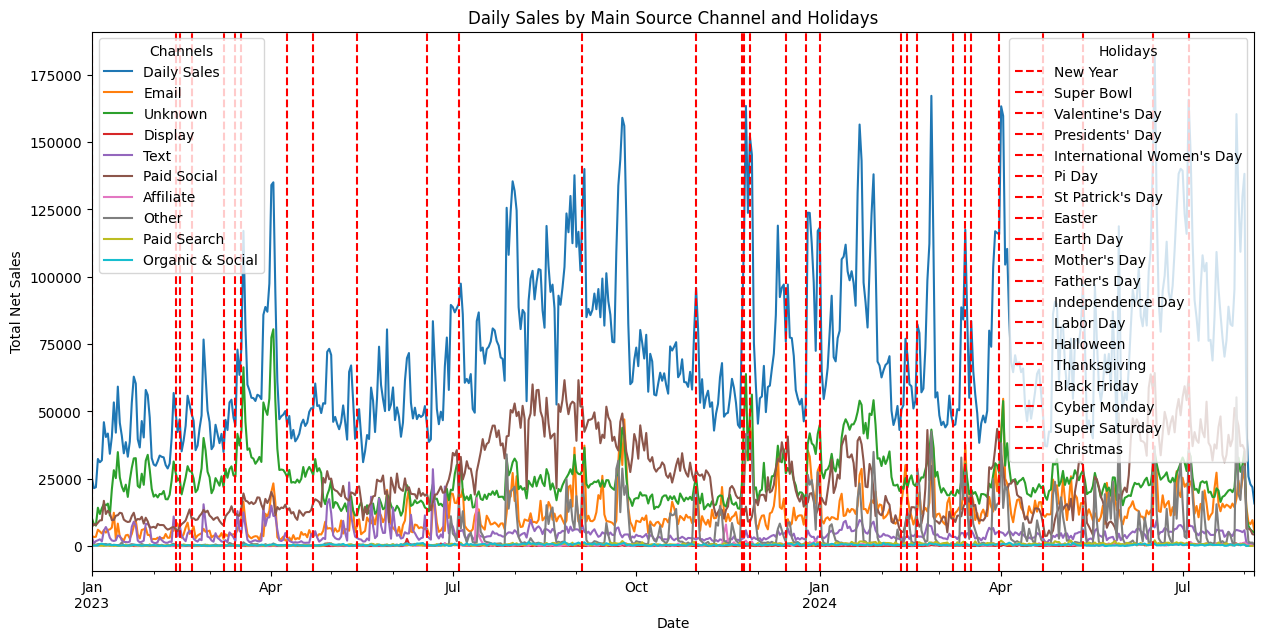

In [17]:
# Example setup; assume unique_orders DataFrame and holidays dictionary are predefined
plt.figure(figsize=(15, 7))

# Plotting daily sales
daily_sales = unique_orders.groupby(pd.Grouper(key="created_at", freq="D"))["Total_Net"].sum()
daily_sales_plot = daily_sales.plot(label='Daily Sales')

# Handles for legends
channel_handles = [daily_sales_plot]  # Start with the handle for daily sales
channel_labels = ['Daily Sales']  # Label for daily sales

# Plotting sales for each channel
for channel in unique_orders.main_source_channel.unique():
    channel_sales = unique_orders[unique_orders['main_source_channel'] == channel].groupby(pd.Grouper(key="created_at", freq="D"))["Total_Net"].sum()
    channel_plot = channel_sales.plot(label=channel)  # Plot and store the Axes object
    # No need to append here; the label is automatically added to the legend

# Marking holidays on the plot
holiday_handles, holiday_labels = [], []
for holiday, dates in holidays.items():
    for date in dates:
        line = plt.axvline(x=date, color='r', linestyle='--')
        if holiday not in holiday_labels:
            holiday_handles.append(line)
            holiday_labels.append(holiday)

# Creating and positioning legends
first_legend = plt.legend(loc='upper left', title="Channels")
plt.gca().add_artist(first_legend)  # Add the first legend manually
second_legend = plt.legend(handles=holiday_handles, labels=holiday_labels, loc='upper right', title="Holidays")

plt.title('Daily Sales by Main Source Channel and Holidays')
plt.xlabel('Date')
plt.ylabel('Total Net Sales')
plt.show()

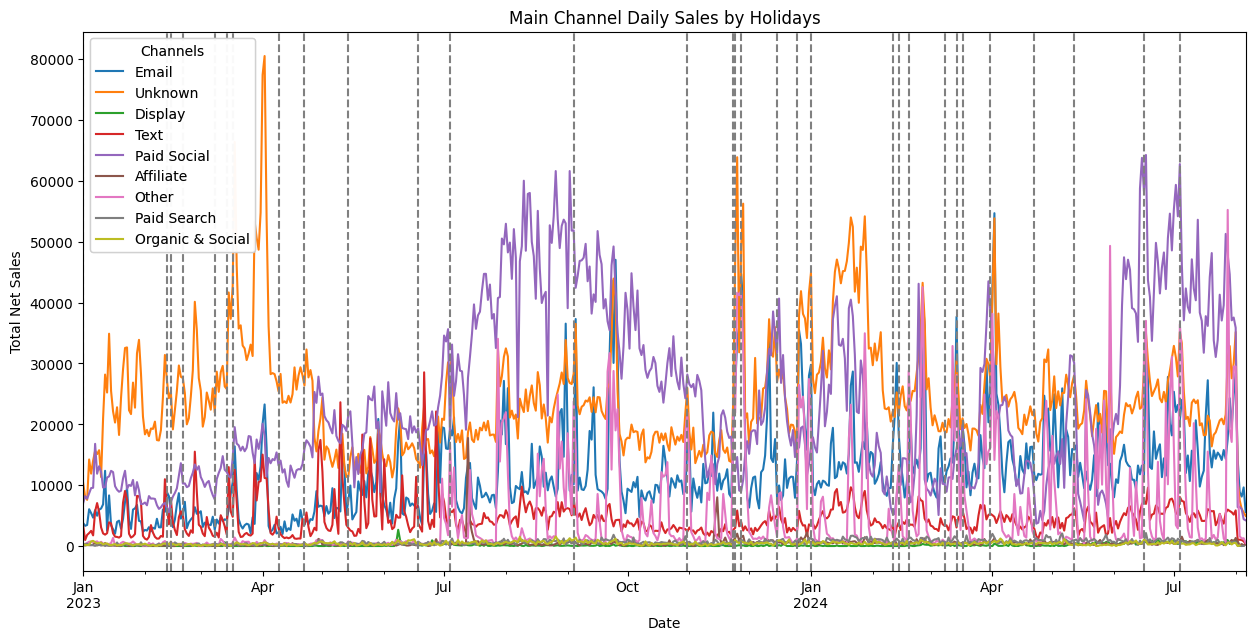

In [18]:
# Example setup; assume unique_orders DataFrame and holidays dictionary are predefined
plt.figure(figsize=(15, 7))

# Plotting sales for each channel
for channel in unique_orders.main_source_channel.unique():
    channel_sales = unique_orders[unique_orders['main_source_channel'] == channel].groupby(pd.Grouper(key="created_at", freq="D"))["Total_Net"].sum()
    channel_plot = channel_sales.plot(label=channel)  # Plot and store the Axes object
    # No need to append here; the label is automatically added to the legend

# Marking holidays on the plot
holiday_handles, holiday_labels = [], []
for holiday, dates in holidays.items():
    for date in dates:
        line = plt.axvline(x=date, color='grey', linestyle='--')
        if holiday not in holiday_labels:
            holiday_handles.append(line)
            holiday_labels.append(holiday)

# Creating and positioning legends
first_legend = plt.legend(loc='upper left', title="Channels")
plt.gca().add_artist(first_legend)  # Add the first legend manually

plt.title('Main Channel Daily Sales by Holidays')
plt.xlabel('Date')
plt.ylabel('Total Net Sales')
plt.show()

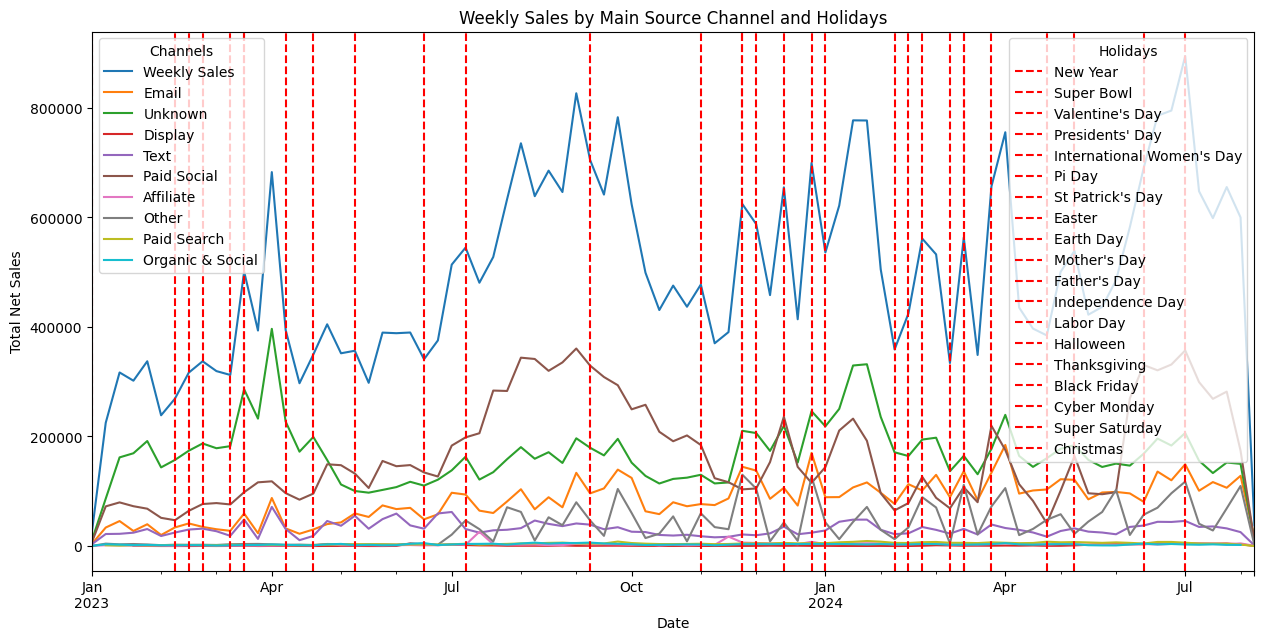

In [19]:
# Example setup; assume unique_orders DataFrame and holidays dictionary are predefined
plt.figure(figsize=(15, 7))

# Plotting weekly sales
weekly_sales = unique_orders.groupby(pd.Grouper(key="created_at", freq="W"))["Total_Net"].sum()
weekly_sales_plot = weekly_sales.plot(label='Weekly Sales')

# Handles for legends
channel_handles = [weekly_sales_plot]  # Start with the handle for weekly sales
channel_labels = ['Weekly Sales']  # Label for weekly sales

# Plotting sales for each channel
for channel in unique_orders.main_source_channel.unique():
    channel_sales = unique_orders[unique_orders['main_source_channel'] == channel].groupby(pd.Grouper(key="created_at", freq="W"))["Total_Net"].sum()
    channel_plot = channel_sales.plot(label=channel)  # Plot and store the Axes object
    # No need to append here; the label is automatically added to the legend

# Marking holidays on the plot
holiday_handles, holiday_labels = [], []
for holiday, dates in holidays.items():
    for date in dates:
        line = plt.axvline(x=date, color='r', linestyle='--')
        if holiday not in holiday_labels:
            holiday_handles.append(line)
            holiday_labels.append(holiday)

# Creating and positioning legends
first_legend = plt.legend(loc='upper left', title="Channels")
plt.gca().add_artist(first_legend)  # Add the first legend manually
second_legend = plt.legend(handles=holiday_handles, labels=holiday_labels, loc='upper right', title="Holidays")

plt.title('Weekly Sales by Main Source Channel and Holidays')
plt.xlabel('Date')
plt.ylabel('Total Net Sales')
plt.show()

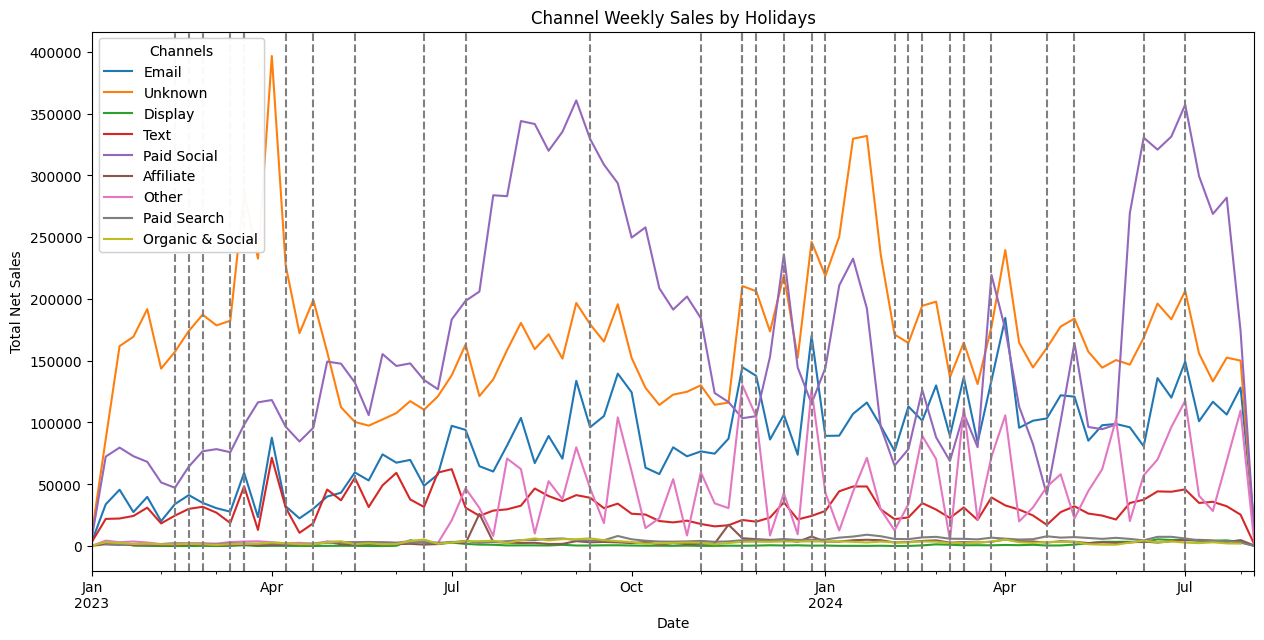

In [20]:
# Example setup; assume unique_orders DataFrame and holidays dictionary are predefined
plt.figure(figsize=(15, 7))

# Plotting sales for each channel
for channel in unique_orders.main_source_channel.unique():
    channel_sales = unique_orders[unique_orders['main_source_channel'] == channel].groupby(pd.Grouper(key="created_at", freq="W"))["Total_Net"].sum()
    channel_plot = channel_sales.plot(label=channel)  # Plot and store the Axes object
    # No need to append here; the label is automatically added to the legend

# Marking holidays on the plot
holiday_handles, holiday_labels = [], []
for holiday, dates in holidays.items():
    for date in dates:
        line = plt.axvline(x=date, color='grey', linestyle='--')
        if holiday not in holiday_labels:
            holiday_handles.append(line)
            holiday_labels.append(holiday)

# Creating and positioning legends
first_legend = plt.legend(loc='upper left', title="Channels")
plt.gca().add_artist(first_legend)  # Add the first legend manually

plt.title('Channel Weekly Sales by Holidays')
plt.xlabel('Date')
plt.ylabel('Total Net Sales')
plt.show()

## Retention rate

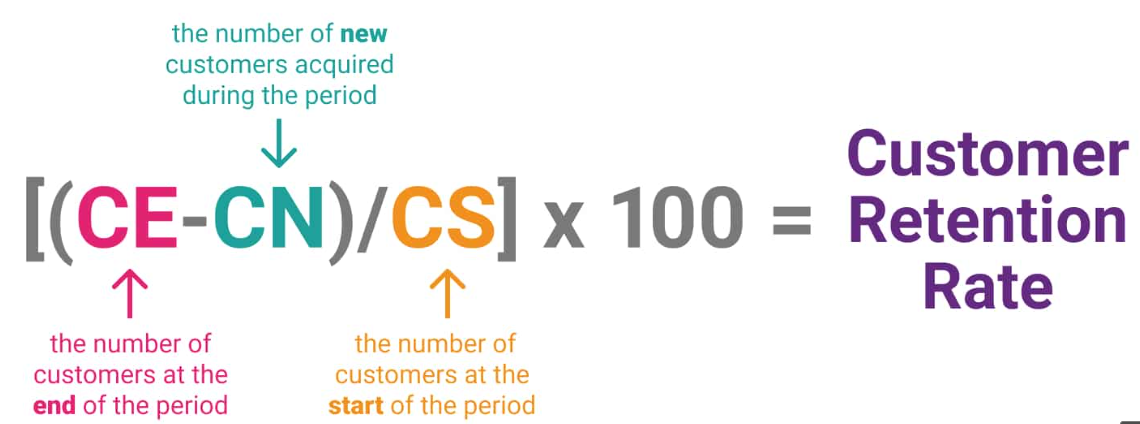

In [21]:
def create_retention_matrix(df):
  months = list(df.groupby(pd.Grouper(key='created_at', freq='M')).groups.keys())
  monthly_retention_matrix_df = pd.DataFrame()
  monthly_retention_rate_matrix_df = pd.DataFrame()

  for i in range(len(months)):
      cur_m = months[i]
      mask = (df['created_at'].dt.month == cur_m.month) & \
              (df['created_at'].dt.year == cur_m.year)
      active_customers = df[mask]['email'].unique()

      for j in range(i, len(months)):
          next_m = months[j]
          mask = (df['created_at'].dt.month == next_m.month) & \
                  (df['created_at'].dt.year == next_m.year) & \
                  df['email'].isin(active_customers)
          retained_customers = df[mask]['email'].nunique()
          monthly_retention_matrix_df.loc[str(cur_m.date()), str(next_m.date())] = retained_customers

          cohort_size = monthly_retention_matrix_df.loc[str(cur_m.date()), str(cur_m.date())]
          monthly_retention_rate_matrix_df.loc[str(cur_m.date()), str(next_m.date())] = monthly_retention_matrix_df.loc[str(cur_m.date()), str(next_m.date())]/cohort_size
      monthly_retention_rate_matrix_df.loc[str(cur_m.date()), str(cur_m.date())] = 1.0


  monthly_retention_matrix_df['Month'] = monthly_retention_matrix_df.index
  monthly_retention_rate_matrix_df['Month'] = monthly_retention_rate_matrix_df.index

  return monthly_retention_matrix_df, monthly_retention_rate_matrix_df

In [22]:
def create_cumulative_retention_matrix(df, monthly_retention_matrix_df):
  months = list(df.groupby(pd.Grouper(key='created_at', freq='M')).groups.keys())
  cumulative_retention_matrix_df = pd.DataFrame()
  cumulative_retention_rate_matrix_df = pd.DataFrame()

  for i in range(len(months)):
      cur_m = months[i]
      cumulative_retention_matrix_df.loc[str(cur_m.date()), str(cur_m.date())] = monthly_retention_matrix_df.loc[str(cur_m.date()), str(cur_m.date())]
      cumulative_retention_rate_matrix_df.loc[str(cur_m.date()), str(cur_m.date())] = monthly_retention_matrix_df.loc[str(cur_m.date()), str(cur_m.date())]

      mask = (df['created_at'].dt.month == cur_m.month) & (df['created_at'].dt.year == cur_m.year)
      active_customers = df[mask]['email'].unique()

      cumulative_retained_customers = []
      for j in range(i+1, len(months)):
          next_m = months[j]
          mask = (df['created_at'].dt.month == next_m.month) & (df['created_at'].dt.year == next_m.year) & df['email'].isin(active_customers)
          retained_customers = df[mask]['email'].unique()
          cumulative_retained_customers.extend(retained_customers)
          cumulative_retention_matrix_df.loc[str(cur_m.date()), str(next_m.date())] = pd.Series(cumulative_retained_customers).nunique()

          cohort_size = cumulative_retention_matrix_df.loc[str(cur_m.date()), str(cur_m.date())]
          cumulative_retention_rate_matrix_df.loc[str(cur_m.date()), str(next_m.date())] = cumulative_retention_matrix_df.loc[str(cur_m.date()), str(next_m.date())]/cohort_size
      cumulative_retention_rate_matrix_df.loc[str(cur_m.date()), str(cur_m.date())] = 1.0


  cumulative_retention_matrix_df['Month'] = cumulative_retention_matrix_df.index
  cumulative_retention_rate_matrix_df['Month'] = cumulative_retention_rate_matrix_df.index

  return cumulative_retention_matrix_df, cumulative_retention_rate_matrix_df

In [23]:
retention_matrix, retention_rate_matrix = create_retention_matrix(unique_orders)
retention_matrix['Cluster'] = 'All'
retention_rate_matrix['Cluster'] = 'All'

cumulative_retention_matrix, cumulative_retention_rate_matrix = create_cumulative_retention_matrix(unique_orders, retention_matrix)
cumulative_retention_matrix['Cluster'] = 'All'
cumulative_retention_rate_matrix['Cluster'] = 'All'

In [24]:
for column in customer_cluster.columns[1:]:
  for cluster in customer_cluster[column].unique():
    cluster_df = unique_orders[unique_orders[column] == cluster]
    cluster_retention_matrix, cluster_retention_rate_matrix = create_retention_matrix(cluster_df)
    cluster_retention_matrix['Cluster'] = cluster
    cluster_retention_rate_matrix['Cluster'] = cluster
    retention_matrix = pd.concat([retention_matrix, cluster_retention_matrix])
    retention_rate_matrix = pd.concat([retention_rate_matrix, cluster_retention_rate_matrix])

    cluster_cumulative_retention_matrix, cluster_cumulative_retention_rate_matrix = create_cumulative_retention_matrix(cluster_df, cluster_retention_matrix)
    cluster_cumulative_retention_matrix['Cluster'] = cluster
    cluster_cumulative_retention_rate_matrix['Cluster'] = cluster
    cumulative_retention_matrix = pd.concat([cumulative_retention_matrix, cluster_cumulative_retention_matrix])
    cumulative_retention_rate_matrix = pd.concat([cumulative_retention_rate_matrix, cluster_cumulative_retention_rate_matrix])

In [25]:
retention_matrix.fillna(0, inplace=True)
retention_rate_matrix.fillna(0, inplace=True)
cumulative_retention_matrix.fillna(0, inplace=True)
cumulative_retention_rate_matrix.fillna(0, inplace=True)

for col in retention_matrix.columns:
  if retention_matrix[col].dtype == 'float64':
    retention_matrix[col] = retention_matrix[col].astype('int')
for col in cumulative_retention_matrix.columns:
  if cumulative_retention_matrix[col].dtype == 'float64':
    cumulative_retention_matrix[col] = cumulative_retention_matrix[col].astype('int')

In [26]:
def cluster_method_col(df):
  conditions = [
      df['Cluster'].str.contains('All'),
      df['Cluster'].str.contains('mcus'),
      df['Cluster'].str.contains('main'),
      df['Cluster'].str.contains('clv'),
      df['Cluster'].str.contains('rfm5'),
      df['Cluster'].str.contains('rfmx'),
      df['Cluster'].str.contains('cb')]

  choices = ['All', 'Most_Commonly_Used_Channel', 'Main Channel', 'CLV', 'RFM5', 'RFMx', 'Customer Behavior']
  df['Cluster_Method'] = np.select(conditions, choices, default='other')

  return df

In [27]:
retention_matrix = cluster_method_col(retention_matrix)
retention_rate_matrix = cluster_method_col(retention_rate_matrix)
cumulative_retention_matrix = cluster_method_col(cumulative_retention_matrix)
cumulative_retention_rate_matrix = cluster_method_col(cumulative_retention_rate_matrix)

In [28]:
cumulative_retention_matrix.head(10)

2023-01-31  2023-02-28  2023-03-31  2023-04-30  2023-05-31  \
2023-01-31       26355        1555        2932        3888        4666   
2023-02-28           0       24691        1877        2999        4029   
2023-03-31           0           0       38782        1878        3593   
2023-04-30           0           0           0       35868        1983   
2023-05-31           0           0           0           0       33150   
2023-06-30           0           0           0           0           0   
2023-07-31           0           0           0           0           0   
2023-08-31           0           0           0           0           0   
2023-09-30           0           0           0           0           0   
2023-10-31           0           0           0           0           0   

            2023-06-30  2023-07-31  2023-08-31  2023-09-30  2023-10-31  ...  \
2023-01-31        5277        5901        6457        6913        7213  ...   
2023-02-28        4818        5506        6110        6662        6977  ...   
2023-03-31        4977        6287        7349        8233        8791  ...   
2023-04-30        3485        4880        6004        6963        7473  ...   
2023-05-31        2425        4262        5769        6996        7657  ...   
2023-06-30       34935        2530        4475        5994        6796  ...   
2023-07-31           0       52206        3541        6220        7667  ...   
2023-08-31           0           0       65232        4249        6681  ...   
2023-09-30           0           0           0       60583        3402  ...   
2023-10-31           0           0           0           0       42166  ...   

            2024-02-29  2024-03-31  2024-04-30  2024-05-31  2024-06-30  \
2023-01-31        8172        8319        8474        8636        8835   
2023-02-28        8019        8193        8349        8474        8645   
2023-03-31       10632       10918       11170       11436       11747   
2023-04-30        9199        9496        9769       10000       10259   
2023-05-31        9641        9911       10153       10449       10798   
2023-06-30        9207        9523        9856       10145       10507   
2023-07-31       11710       12241       12763       13249       13859   
2023-08-31       12761       13456       14128       14770       15580   
2023-09-30       11372       12291       13113       13858       14665   
2023-10-31        7688        8489        9185        9769       10465   

            2024-07-31  2024-08-31       Month  Cluster  Cluster_Method  
2023-01-31        8989        9006  2023-01-31      All             All  
2023-02-28        8793        8825  2023-02-28      All             All  
2023-03-31       12025       12066  2023-03-31      All             All  
2023-04-30       10528       10567  2023-04-30      All             All  
2023-05-31       11061       11102  2023-05-31      All             All  
2023-06-30       10809       10844  2023-06-30      All             All  
2023-07-31       14397       14477  2023-07-31      All             All  
2023-08-31       16187       16300  2023-08-31      All             All  
2023-09-30       15316       15409  2023-09-30      All             All  
2023-10-31       10994       11067  2023-10-31      All             All  

[10 rows x 23 columns]

In [29]:
cumulative_retention_rate_matrix.head(10)

2023-01-31  2023-02-28  2023-03-31  2023-04-30  2023-05-31  \
2023-01-31         1.0    0.059002     0.11125    0.147524    0.177044   
2023-02-28         0.0    1.000000     0.07602    0.121461    0.163177   
2023-03-31         0.0    0.000000     1.00000    0.048425    0.092646   
2023-04-30         0.0    0.000000     0.00000    1.000000    0.055286   
2023-05-31         0.0    0.000000     0.00000    0.000000    1.000000   
2023-06-30         0.0    0.000000     0.00000    0.000000    0.000000   
2023-07-31         0.0    0.000000     0.00000    0.000000    0.000000   
2023-08-31         0.0    0.000000     0.00000    0.000000    0.000000   
2023-09-30         0.0    0.000000     0.00000    0.000000    0.000000   
2023-10-31         0.0    0.000000     0.00000    0.000000    0.000000   

            2023-06-30  2023-07-31  2023-08-31  2023-09-30  2023-10-31  ...  \
2023-01-31    0.200228    0.223904    0.245001    0.262303    0.273686  ...   
2023-02-28    0.195132    0.222996    0.247459    0.269815    0.282573  ...   
2023-03-31    0.128333    0.162111    0.189495    0.212289    0.226677  ...   
2023-04-30    0.097162    0.136054    0.167392    0.194128    0.208347  ...   
2023-05-31    0.073152    0.128567    0.174027    0.211041    0.230980  ...   
2023-06-30    1.000000    0.072420    0.128095    0.171576    0.194533  ...   
2023-07-31    0.000000    1.000000    0.067827    0.119143    0.146861  ...   
2023-08-31    0.000000    0.000000    1.000000    0.065137    0.102419  ...   
2023-09-30    0.000000    0.000000    0.000000    1.000000    0.056154  ...   
2023-10-31    0.000000    0.000000    0.000000    0.000000    1.000000  ...   

            2024-02-29  2024-03-31  2024-04-30  2024-05-31  2024-06-30  \
2023-01-31    0.310074    0.315652    0.321533    0.327680    0.335231   
2023-02-28    0.324774    0.331821    0.338139    0.343202    0.350128   
2023-03-31    0.274148    0.281522    0.288020    0.294879    0.302898   
2023-04-30    0.256468    0.264749    0.272360    0.278800    0.286021   
2023-05-31    0.290830    0.298974    0.306275    0.315204    0.325732   
2023-06-30    0.263547    0.272592    0.282124    0.290396    0.300759   
2023-07-31    0.224304    0.234475    0.244474    0.253783    0.265468   
2023-08-31    0.195625    0.206279    0.216581    0.226423    0.238840   
2023-09-30    0.187709    0.202879    0.216447    0.228744    0.242065   
2023-10-31    0.182327    0.201323    0.217830    0.231680    0.248186   

            2024-07-31  2024-08-31       Month  Cluster  Cluster_Method  
2023-01-31    0.341074    0.341719  2023-01-31      All             All  
2023-02-28    0.356122    0.357418  2023-02-28      All             All  
2023-03-31    0.310067    0.311124  2023-03-31      All             All  
2023-04-30    0.293521    0.294608  2023-04-30      All             All  
2023-05-31    0.333665    0.334902  2023-05-31      All             All  
2023-06-30    0.309403    0.310405  2023-06-30      All             All  
2023-07-31    0.275773    0.277305  2023-07-31      All             All  
2023-08-31    0.248145    0.249877  2023-08-31      All             All  
2023-09-30    0.252810    0.254345  2023-09-30      All             All  
2023-10-31    0.260731    0.262463  2023-10-31      All             All  

[10 rows x 23 columns]

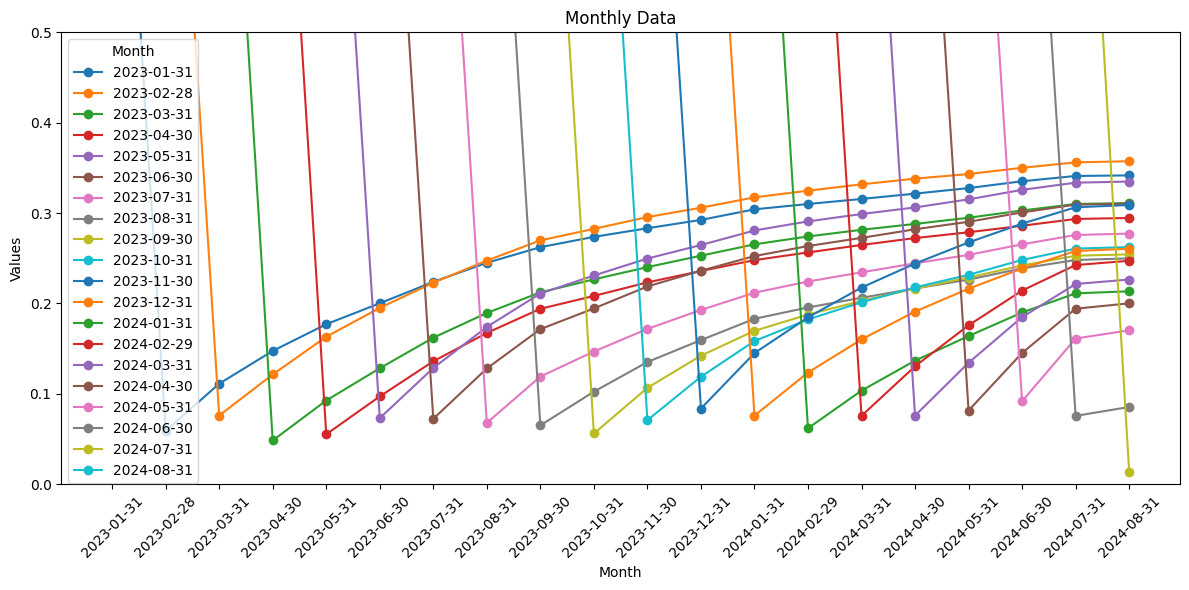

In [30]:
df = cumulative_retention_rate_matrix[cumulative_retention_rate_matrix['Cluster'] == 'All'].copy()

plt.figure(figsize=(12, 6))

# Iterate over each unique value in the Month column
for month in df['Month']:
    values = df[df['Month'] == month].iloc[:, :-3].values.flatten()
    non_zero_values = [v if v != 0 else None for v in values]  # Replace 0 with None
    plt.plot(df['Month'].unique(), non_zero_values, marker='o', label=month)

# Customize the plot
plt.title('Monthly Data')
plt.xlabel('Month')
plt.ylabel('Values')
plt.legend(title='Month')
plt.xticks(rotation=45)
plt.tight_layout()
plt.ylim(0, 0.5)
plt.show()

In [31]:
project_id = 'fb-business-datasets'  # Google Cloud project ID
destination_table = 'fb-business-datasets.ds_tables.retention_matrix_newest'  # destination table name in BigQuery
retention_matrix.to_gbq(destination_table, project_id=project_id, if_exists='replace')

100%|██████████| 1/1 [00:00<00:00, 5924.16it/s]


In [32]:
project_id = 'fb-business-datasets'  # Google Cloud project ID
destination_table = 'fb-business-datasets.ds_tables.retention_rate_matrix_newest'  # destination table name in BigQuery
retention_rate_matrix.to_gbq(destination_table, project_id=project_id, if_exists='replace')

100%|██████████| 1/1 [00:00<00:00, 1493.17it/s]


In [33]:
project_id = 'fb-business-datasets'  # Google Cloud project ID
destination_table = 'fb-business-datasets.ds_tables.cumulative_retention_matrix_newest'  # destination table name in BigQuery
cumulative_retention_matrix.to_gbq(destination_table, project_id=project_id, if_exists='replace')

100%|██████████| 1/1 [00:00<00:00, 1582.16it/s]


In [34]:
project_id = 'fb-business-datasets'  # Google Cloud project ID
destination_table = 'fb-business-datasets.ds_tables.cumulative_retention_rate_matrix_newest'  # destination table name in BigQuery
cumulative_retention_rate_matrix.to_gbq(destination_table, project_id=project_id, if_exists='replace')

100%|██████████| 1/1 [00:00<00:00, 749.38it/s]


## Average Order Value

In [35]:
unique_orders['Month'] = unique_orders['created_at'].dt.to_period('M')
aov_df = pd.DataFrame()

for col in customer_cluster.columns[1:]:
    aov_overall = unique_orders.groupby(col)['Total_Net'].mean().reset_index()
    aov_overall['Month'] = 'Overall'
    aov_overall.rename(columns={col: 'Cluster', 'Total_Net': 'Average_Order_Value'}, inplace=True)
    aov_monthly = unique_orders.groupby([col, 'Month'])['Total_Net'].mean().reset_index()
    aov_monthly.rename(columns={col: 'Cluster', 'Total_Net': 'Average_Order_Value'}, inplace=True)
    aov_df = pd.concat([aov_df, aov_overall, aov_monthly], ignore_index=True)

aov_df['Cluster'] = aov_df['Cluster'].astype('str')
aov_df['Month'] = aov_df['Month'].astype('str')
aov_df.sort_values(by=['Cluster', 'Month'], inplace=True)

<ipython-input-35-35dc99944b05>:1: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  unique_orders['Month'] = unique_orders['created_at'].dt.to_period('M')


In [36]:
aov_df = cluster_method_col(aov_df)

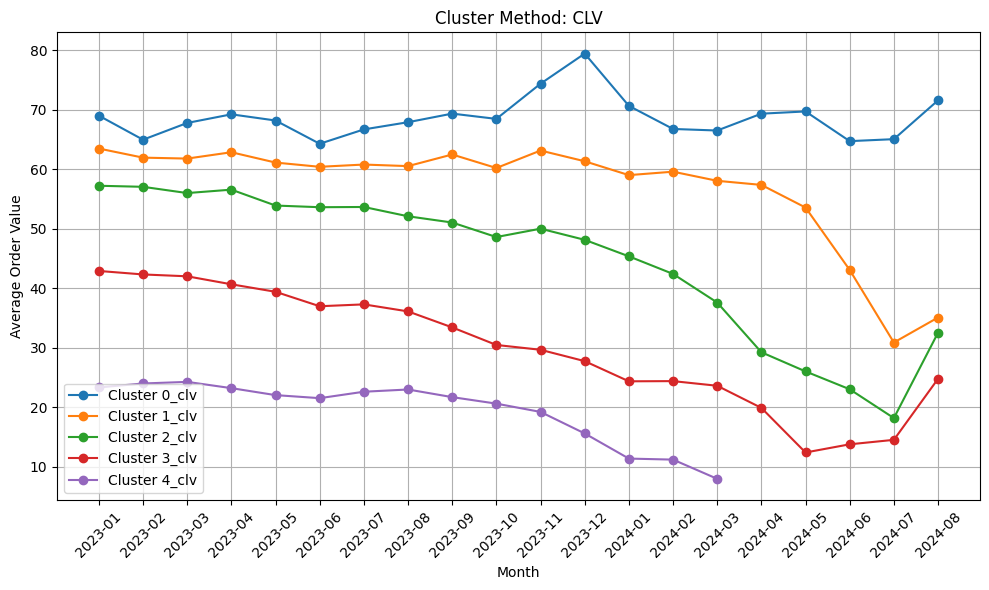

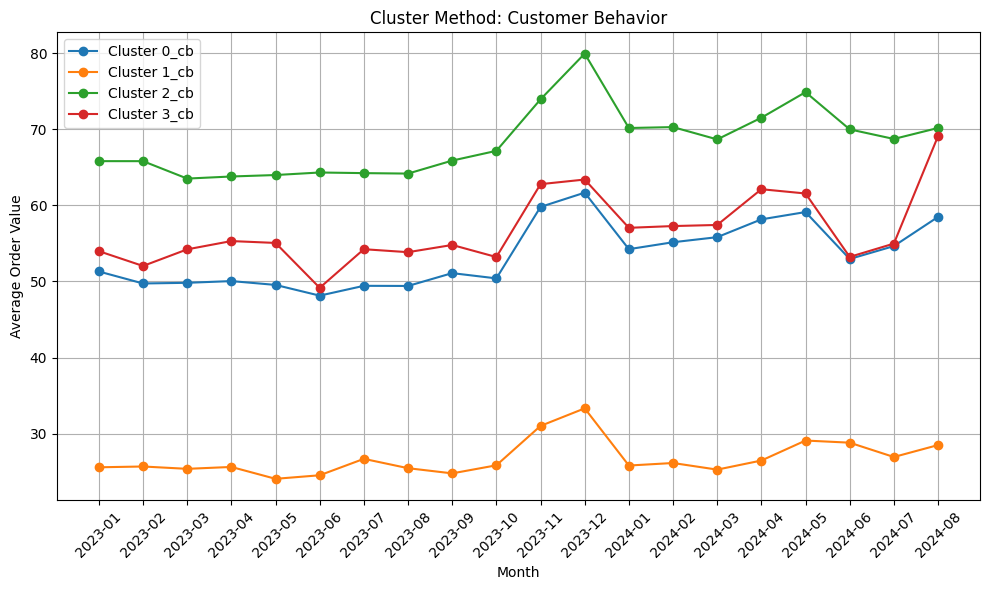

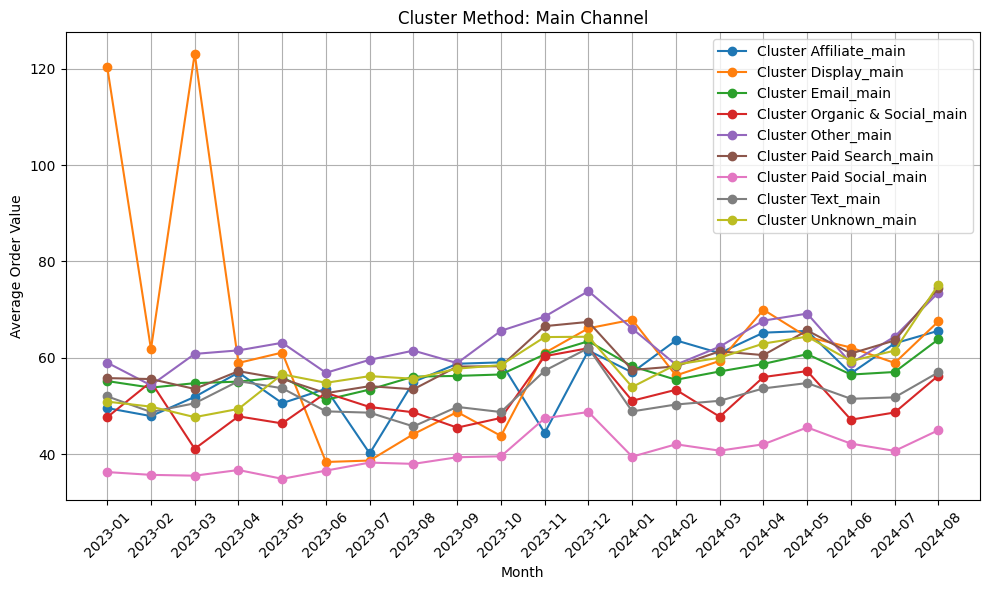

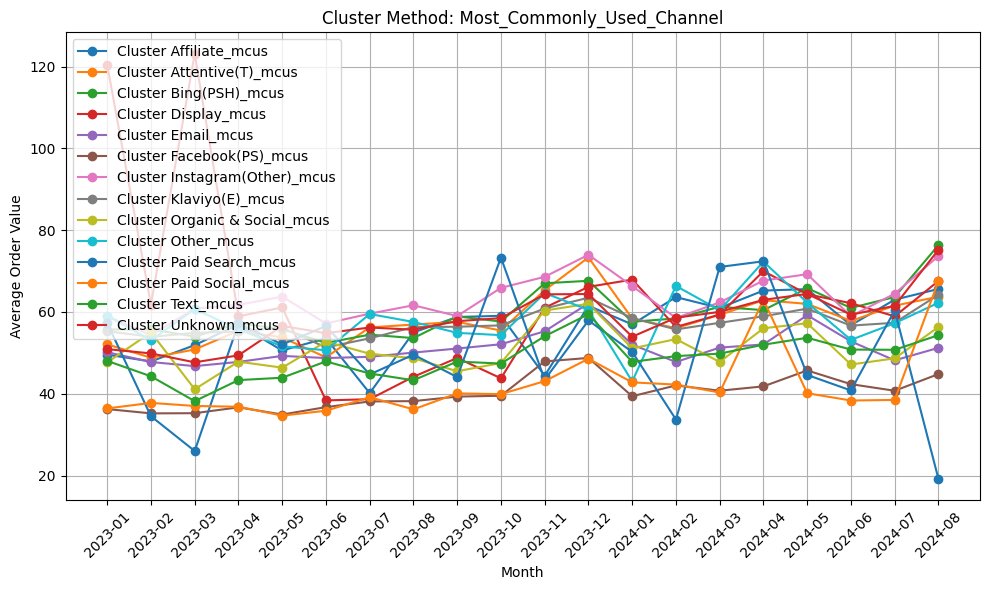

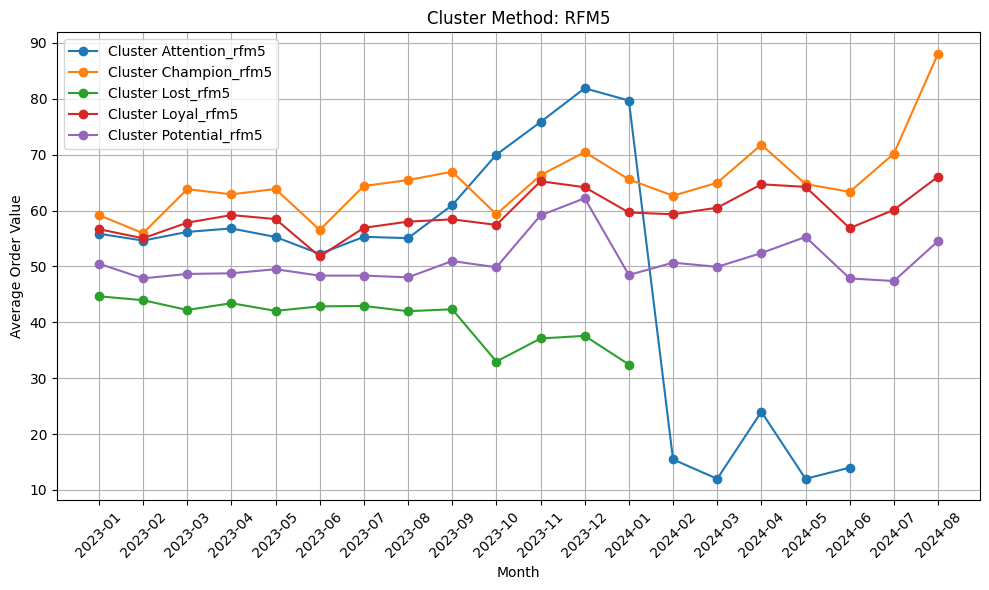

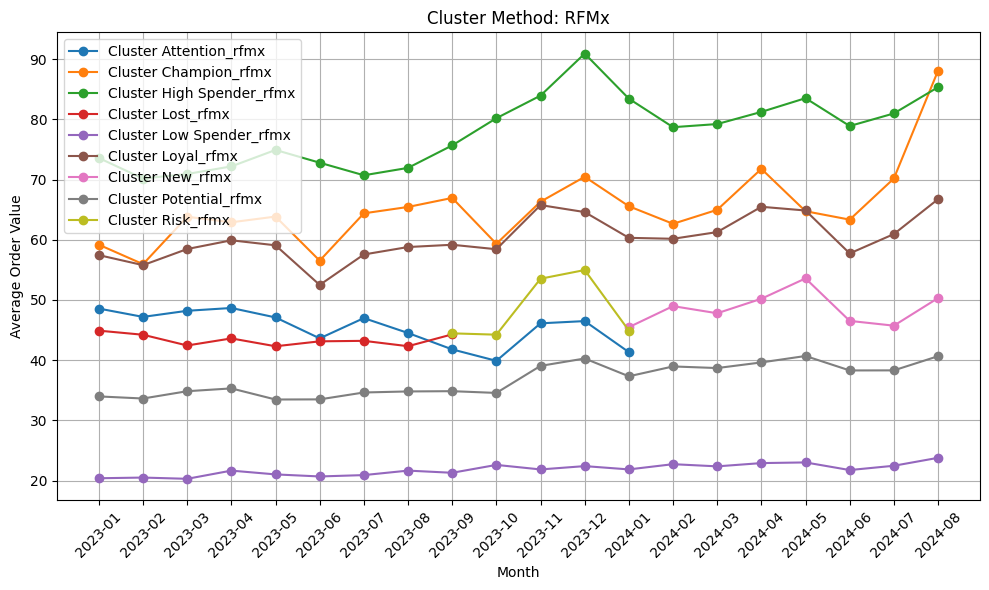

In [37]:
aov_df['Month'] = pd.Categorical(aov_df['Month'], ordered=True)

for method, group in aov_df[aov_df['Month'] != 'Overall'].groupby('Cluster_Method'):
    plt.figure(figsize=(10, 6))
    for cluster, cluster_group in group.groupby('Cluster'):
        plt.plot(cluster_group['Month'], cluster_group['Average_Order_Value'], marker='o', label=f'Cluster {cluster}')
    plt.title(f'Cluster Method: {method}')
    plt.xlabel('Month')
    plt.ylabel('Average Order Value')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [38]:
aov_df

Cluster  Average_Order_Value    Month              Cluster_Method
827          0_cb            51.305704  2023-01           Customer Behavior
828          0_cb            49.733336  2023-02           Customer Behavior
829          0_cb            49.819728  2023-03           Customer Behavior
830          0_cb            50.046793  2023-04           Customer Behavior
831          0_cb            49.543093  2023-05           Customer Behavior
..            ...                  ...      ...                         ...
290  Unknown_mcus            64.404366  2024-05  Most_Commonly_Used_Channel
291  Unknown_mcus            59.323604  2024-06  Most_Commonly_Used_Channel
292  Unknown_mcus            61.491068  2024-07  Most_Commonly_Used_Channel
293  Unknown_mcus            75.193946  2024-08  Most_Commonly_Used_Channel
13   Unknown_mcus            56.616522  Overall  Most_Commonly_Used_Channel

[907 rows x 4 columns]

In [39]:
project_id = 'fb-business-datasets'  # Google Cloud project ID
destination_table = 'fb-business-datasets.ds_tables.aov_newest'  # destination table name in BigQuery
aov_df.to_gbq(destination_table, project_id=project_id, if_exists='replace')

100%|██████████| 1/1 [00:00<00:00, 752.75it/s]


## Customer LifeTime Value

Customer LifeTime Value = Purchase Frequency * Average order Value * Average Customer Lifespan

In [40]:
cltv_df = pd.DataFrame()

for col in customer_cluster.columns[1:]:
    summary = unique_orders.groupby(['email', col]).agg(
        total_net=('Total_Net', 'sum'),
        num_orders=('Total_Net', 'count'),
        first_purchase=('created_at', 'min'),
        last_purchase=('created_at', 'max')
    ).reset_index()

    summary['AOV'] = summary['total_net'] / summary['num_orders']

    purchase_frequency = summary.groupby(col).agg(
        num_customers=('email', 'nunique'),
        total_orders=('num_orders', 'sum')
    ).reset_index()
    purchase_frequency['frequency'] = purchase_frequency['total_orders'] / purchase_frequency['num_customers']

    summary = summary.merge(purchase_frequency[[col, 'frequency']], on=col)
    summary['customer_value'] = summary['AOV'] * summary['frequency']
    summary['customer_lifespan_months'] = ((summary['last_purchase'] - summary['first_purchase']).dt.days / 30).apply(lambda x: max(1, x))

    summary['CLTV'] = summary['customer_value'] * summary['customer_lifespan_months']

    col_cltv = summary.groupby(col).agg(
        AOV = ('AOV', 'mean'),
        frequency = ('frequency', 'mean'),
        CV = ('customer_value', 'mean'),
        ACL = ('customer_lifespan_months', 'mean'),
        CLTV = ('CLTV', 'mean')
    ).reset_index()

    col_cltv.rename(columns={col: 'Cluster'}, inplace=True)
    cltv_df = pd.concat([cltv_df, col_cltv], ignore_index=True)

cltv_df.sort_values(by=['Cluster'], inplace=True)

In [41]:
cltv_df = cluster_method_col(cltv_df)

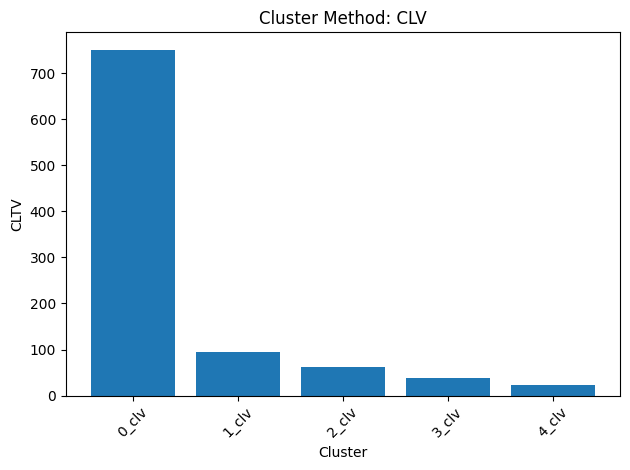

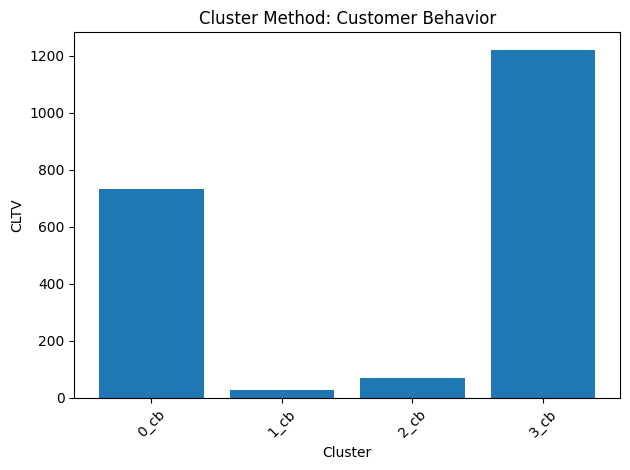

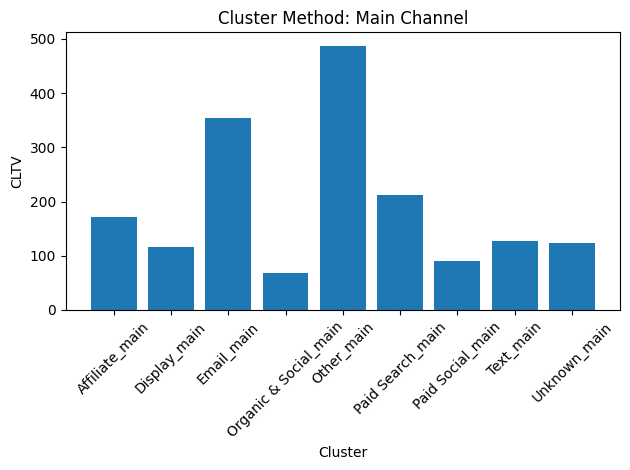

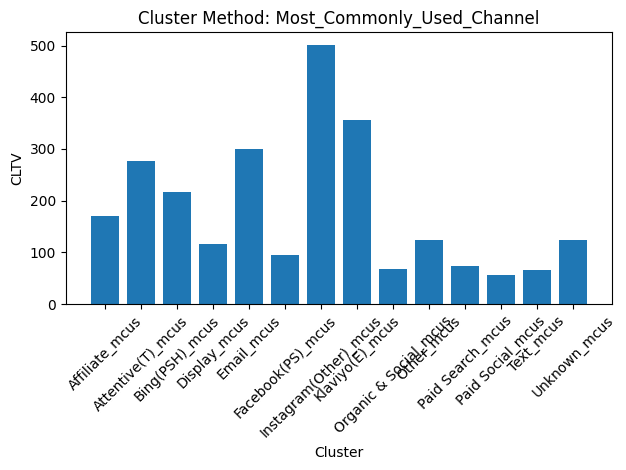

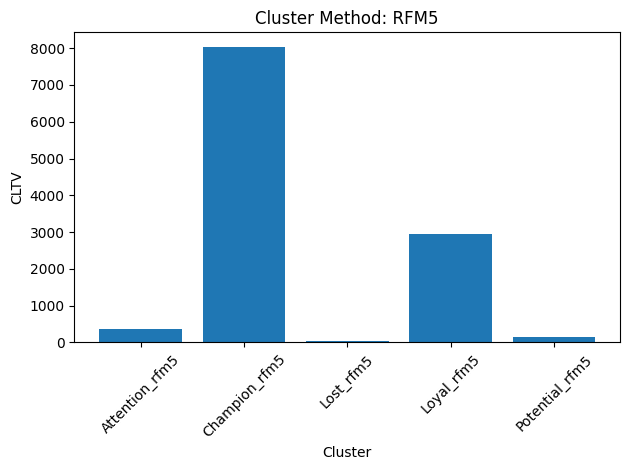

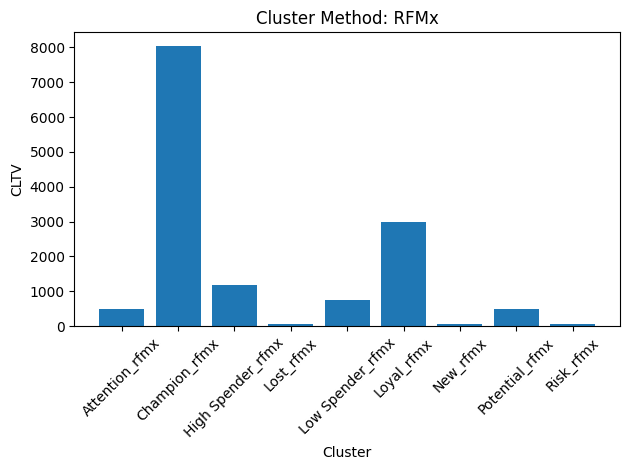

In [42]:
for method, group in cltv_df.groupby('Cluster_Method'):
    plt.figure()
    group_sorted = group.sort_values('Cluster')
    plt.bar(group_sorted['Cluster'].astype(str), group_sorted['CLTV'])
    plt.title(f'Cluster Method: {method}')
    plt.xlabel('Cluster')
    plt.ylabel('CLTV')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [43]:
cltv_df

Cluster        AOV  frequency          CV        ACL  \
42                   0_cb  52.473508   2.398227  125.843409   5.735810   
23                  0_clv  77.123918   2.406638  185.609372   4.817245   
43                   1_cb  26.541640   1.001598   26.584042   1.001147   
24                  1_clv  55.132058   1.209709   66.693764   1.651181   
44                   2_cb  68.189125   1.003607   68.435050   1.000000   
25                  2_clv  46.776776   1.120391   52.408264   1.314254   
45                   3_cb  52.884177   3.673954  194.294053   5.874790   
26                  3_clv  32.851041   1.076853   35.375738   1.130527   
27                  4_clv  22.598554   1.026336   23.193714   1.019510   
14         Affiliate_main  52.584669   1.401143   73.678618   2.190123   
0          Affiliate_mcus  52.584669   1.401143   73.678618   2.190123   
28         Attention_rfm5  77.405007   1.910566  147.887395   2.971456   
33         Attention_rfmx  41.643533   2.636519  109.793955   4.438276   
1       Attentive(T)_mcus  51.094576   1.582970   80.881177   3.119080   
2          Bing(PSH)_mcus  58.539512   1.472619   86.206415   2.425431   
29          Champion_rfm5  64.046899   9.093886  582.435183  13.631685   
34          Champion_rfmx  64.046899   9.093886  582.435183  13.631685   
15           Display_main  52.691469   1.207071   63.602329   1.675132   
3            Display_mcus  52.691469   1.207071   63.602329   1.675132   
16             Email_main  54.990778   1.922891  105.741296   3.178332   
4              Email_mcus  50.738381   2.205235  111.890052   2.601844   
5       Facebook(PS)_mcus  39.313748   1.275634   50.149947   1.808728   
35      High Spender_rfmx  81.645380   2.478341  202.345116   6.009069   
6   Instagram(Other)_mcus  61.460937   2.022310  124.293095   3.843751   
7         Klaviyo(E)_mcus  55.100613   1.915599  105.550667   3.193222   
30              Lost_rfm5  40.946101   1.103749   45.194235   1.157773   
36              Lost_rfmx  42.750584   1.111676   47.524817   1.143541   
37       Low Spender_rfmx  21.784920   4.060120   88.449393   8.514830   
31             Loyal_rfm5  58.876348   4.786785  281.828416  10.357854   
38             Loyal_rfmx  59.717028   4.803218  286.833891  10.364620   
39               New_rfmx  47.819948   1.000000   47.819948   1.000000   
17  Organic & Social_main  49.779683   1.083999   53.961128   1.230130   
8   Organic & Social_mcus  49.779683   1.083999   53.961128   1.230130   
18             Other_main  61.328517   2.001914  122.774423   3.786289   
9              Other_mcus  56.478330   1.254848   70.871699   1.681579   
19       Paid Search_main  58.359882   1.463216   85.393138   2.391888   
10       Paid Search_mcus  52.028295   1.131783   58.884736   1.209561   
20       Paid Social_main  39.161756   1.260552   49.365415   1.761163   
11       Paid Social_mcus  37.670648   1.112589   41.911960   1.294534   
32         Potential_rfm5  49.017370   1.330782   65.231422   2.295979   
40         Potential_rfmx  38.395653   2.172931   83.431120   5.898521   
41              Risk_rfmx  48.808657   1.000000   48.808657   1.000000   
21              Text_main  49.735748   1.269870   63.157941   1.885213   
12              Text_mcus  48.999550   1.100236   53.911083   1.216718   
22           Unknown_main  54.143289   1.270328   68.779721   1.667418   
13           Unknown_mcus  54.143289   1.270328   68.779721   1.667418   

           CLTV              Cluster_Method  
42   733.544643           Customer Behavior  
23   751.512204                         CLV  
43    26.605022           Customer Behavior  
24    93.508626                         CLV  
44    68.435050           Customer Behavior  
25    62.074705                         CLV  
45  1220.485446           Customer Behavior  
26    38.732891                         CLV  
27    23.597222                         CLV  
14   171.057391                Main Channel  
0    171.057391  Most_Commonly_Us

In [44]:
project_id = 'fb-business-datasets'  # Google Cloud project ID
destination_table = 'fb-business-datasets.ds_tables.cltv_newest'  # destination table name in BigQuery
cltv_df.to_gbq(destination_table, project_id=project_id, if_exists='replace')

100%|██████████| 1/1 [00:00<00:00, 7869.24it/s]


## Recommendation

I analyze the cleansed customer data to pinpoint the top-selling products within each cluster. Leveraging this information, the system will craft personalized recommendations, suggesting the top three products popular within their cluster that they have not yet purchased. This not only facilitates targeted marketing strategies but also enriches the personal shopping experience, potentially boosting sales.

In [45]:
cleaned_orderlines.columns

Index(['order_number', 'created_at', 'shipping_address_province_code', 'email',
       'source_channel', 'sku', 'title', 'quantity', 'revenue', 'net',
       'Most_Commonly_Used_Channel', 'Main_Channel', 'cluster_clv',
       'cluster_rfm5', 'cluster_rfmx', 'cluster_cb'],
      dtype='object')

In [46]:
best_selling_df = pd.DataFrame()

for col in customer_cluster.columns[1:]:
    best_selling_products = cleaned_orderlines.groupby([col, 'sku']).agg(
        total_quantity = ('quantity', 'sum'),
        num_orders = ('order_number', 'nunique')
    ).reset_index()

    best_selling_products = best_selling_products.sort_values(by=[col, 'total_quantity'], ascending=[True, False])
    top_products_per_cluster = best_selling_products.groupby(col).head(10)
    top_products_per_cluster.rename(columns={col: 'cluster'}, inplace=True)

    best_selling_df = pd.concat([best_selling_df, top_products_per_cluster], ignore_index=True)

best_selling_df

<ipython-input-46-f5398e9ff19e>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_products_per_cluster.rename(columns={col: 'cluster'}, inplace=True)
<ipython-input-46-f5398e9ff19e>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_products_per_cluster.rename(columns={col: 'cluster'}, inplace=True)
<ipython-input-46-f5398e9ff19e>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_products_per_cluster.rename(columns={col: 'cl

cluster    sku  total_quantity  num_orders
0    Affiliate_mcus  CW574            1189         998
1    Affiliate_mcus  CW526            1085         933
2    Affiliate_mcus  CW566             976         890
3    Affiliate_mcus  CW527             962         799
4    Affiliate_mcus  CW528             659         593
..              ...    ...             ...         ...
455            3_cb  CW522           14153       12500
456            3_cb  CW565           11384        9896
457            3_cb  CW515           10642        9598
458            3_cb  CW511           10344        9520
459            3_cb  CW574           10101        7979

[460 rows x 4 columns]

In [ ]:
recommendations_dfs = {}

for method in ['cluster_clv', 'cluster_rfm5', 'cluster_rfmx', 'cluster_cb']:
    customer_purchases = cleaned_orderlines.groupby(['email', method, 'sku'])['quantity'].sum().reset_index()

    all_recommendations = {}
    customer_purchases_by_email_cluster = customer_purchases.groupby(['email', method])['sku'].apply(set).to_dict()

    for cluster in customer_purchases[method].unique():
        recommendations_cluster = []
        best_selling_cluster = best_selling_df[best_selling_df['cluster'] == cluster]
        customers_in_cluster = cleaned_orderlines[cleaned_orderlines[method] == cluster]['email'].unique()

        for customer in customers_in_cluster:
            # Identify products already purchased by the customer in the current cluster
            customer_purchased_products = customer_purchases_by_email_cluster.get((customer, cluster), set())
            # Find top 3 products in the best-selling list that the customer hasn't purchased yet
            top_products_not_purchased = best_selling_cluster[~best_selling_cluster['sku'].isin(customer_purchased_products)]
            top_3_products_not_purchased = top_products_not_purchased.head(3)
            # Append the recommendations to the list
            recommendations_cluster.append([customer] + top_3_products_not_purchased['sku'].values.flatten().tolist())

        all_recommendations[cluster] = recommendations_cluster

    flattened_recommendations = []
    for cluster, recommendations in all_recommendations.items():
        for recommendation in recommendations:
            flattened_recommendations.append([method, cluster] + recommendation)

    recommendations_df = pd.DataFrame(flattened_recommendations, columns=['cluster_method', 'cluster', 'email', 'Recommendation1', 'Recommendation2', 'Recommendation3'])
    recommendations_dfs[method] = recommendations_df

combined_recommendations_df = pd.concat(recommendations_dfs.values(), ignore_index=True)

In [ ]:
combined_recommendations_df.head()

In [ ]:
project_id = 'fb-business-datasets'  # Google Cloud project ID
destination_table = 'fb-business-datasets.ds_tables.best_selling_newest'  # destination table name in BigQuery
best_selling_df.to_gbq(destination_table, project_id=project_id, if_exists='replace')

In [ ]:
project_id = 'fb-business-datasets'  # Google Cloud project ID
destination_table = 'fb-business-datasets.ds_tables.recommendations_newest'  # destination table name in BigQuery
combined_recommendations_df.to_gbq(destination_table, project_id=project_id, if_exists='replace')

In [ ]:
%%bigquery best_selling --project fb-business-datasets
SELECT *
FROM fb-business-datasets.ds_tables.best_selling_newest

In [ ]:
%%bigquery recommendations --project fb-business-datasets
SELECT *
FROM fb-business-datasets.ds_tables.recommendations_newest

In [ ]:
recommendations.tail()

In [ ]:
recommendations[recommendations['email'] == 'atwell5390@gmail.com']

In [ ]:
recommendations[recommendations['email'] == 'maryleelong25@comcast.net']